In [1]:
# Import dependencies
import os
import glob
import re
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt

import conf as cf
from model_openai import Model_OpenAI

In [2]:
# Set parameters

# Just uncomment if you want to create a new workspace
#version = datetime.datetime.now().strftime('%Y%m%d')
version = "20231002"
workspace = os.path.join(cf.path_data_workspace,version)
os.makedirs(workspace, exist_ok=True)


# Load all inputs


In [7]:
# Create
step1 = "01-join inputs"
step1_ws = os.path.join(workspace,step1)
os.makedirs(step1_ws, exist_ok=True)
file_sorting_save = os.path.join(step1_ws,"01-inputs-full-raw.csv")
file_duplicates = os.path.join(step1_ws,"02-inputs-cleaning.csv")

In [6]:
csv_files = glob.glob(os.path.join(cf.path_data_inputs,"*.csv"))

inputs_df = pd.DataFrame()

# Iterate through each CSV file and read it into a DataFrame, then concatenate it with the combined DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df["source"] = file.split('\\')[-1]
    print("\tLoading",file,"current",inputs_df.shape,"new",df.shape)
    inputs_df = pd.concat([inputs_df, df], ignore_index=True)


# Add id
inputs_df.insert(0, 'id', range(1, 1 + len(inputs_df)))

# Print the combined DataFrame
print(inputs_df.head())

# Sorting and saving
inputs_df = inputs_df.sort_values(by=["intent","text"])
inputs_df.to_csv(file_sorting_save,encoding=cf.encoding_utf,index=False)

print("Size full",inputs_df.shape)

# Removing duplicates and nan
inputs_df = inputs_df.drop_duplicates(subset=["intent","text"], keep="last")
inputs_df = inputs_df.dropna()
inputs_df.to_csv(file_duplicates,encoding=cf.encoding_utf,index=False)

print("Size without duplicates and nan",inputs_df.shape)

	Loading D:\CIAT\Code\USAID\melisa_demeter\data\inputs\inputs_chats.csv current (0, 0) new (2741, 3)
	Loading D:\CIAT\Code\USAID\melisa_demeter\data\inputs\inputs_mta.csv current (2741, 3) new (565, 3)
   id             text     intent            source
0   1  [object Object]  cultivars  inputs_chats.csv
1   2             Hola         hi  inputs_chats.csv
2   3             Hola         hi  inputs_chats.csv
3   4             Hola         hi  inputs_chats.csv
4   5             Hola         hi  inputs_chats.csv
Size full (3306, 4)
Size without duplicates and nan (3024, 4)


Text(0.5, 1.0, 'Histogram of character lengths in text')

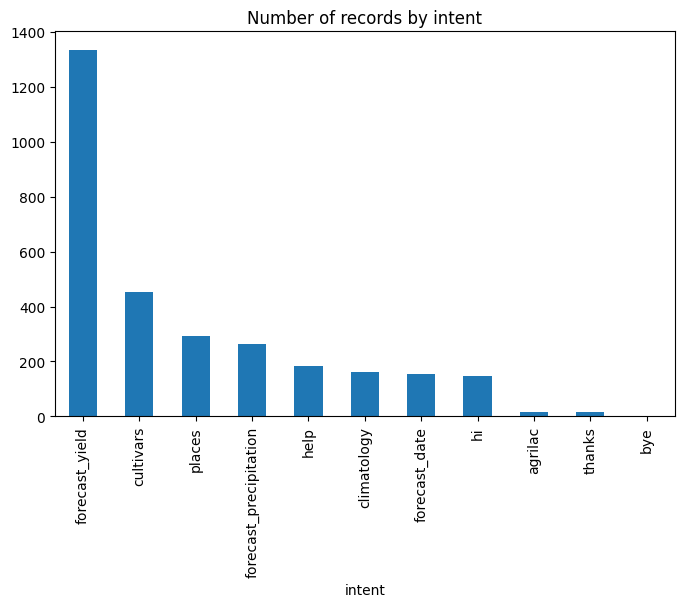

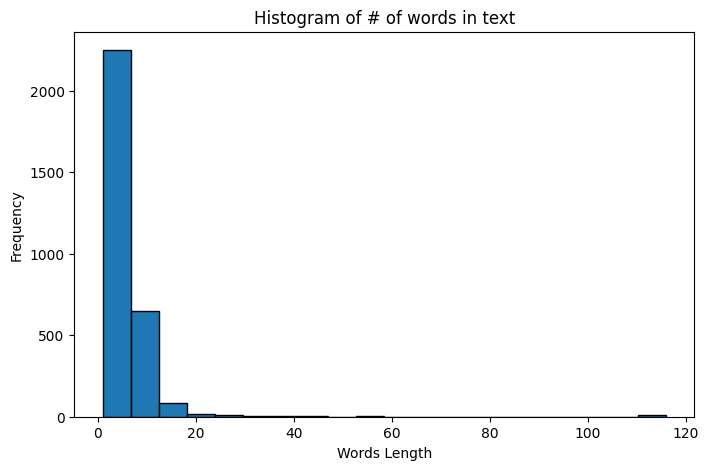

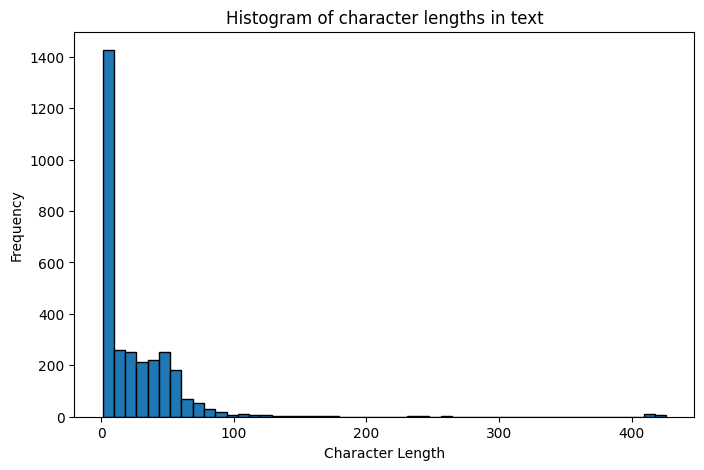

In [7]:
#inputs_df = pd.read_csv(file_duplicates,encoding=cf.encoding_utf)

# Number of records by intent
plt.figure(figsize=(8,5))
ax1 = inputs_df['intent'].value_counts().plot(kind='bar')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Number of records by intent")

# Histogram about length of strings
inputs_df['word_length'] = inputs_df['text'].apply(lambda x: len(str(x).split(' ')))
# Plot a histogram of the word lengths (length of characters)
plt.figure(figsize=(8, 5))
plt.hist(inputs_df['word_length'], bins=20, edgecolor='black')
# Add labels and title
plt.xlabel('Words Length')
plt.ylabel('Frequency')
plt.title('Histogram of # of words in text')

# Histogram about length of strings
inputs_df['character_length'] = inputs_df['text'].apply(lambda x: len(str(x)))
# Plot a histogram of the word lengths (length of characters)
plt.figure(figsize=(8, 5))
plt.hist(inputs_df['character_length'], bins=50, edgecolor='black')
# Add labels and title
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Histogram of character lengths in text')

# Filtering

In [3]:
# Create
step2 = "02-filtering"
step2_ws = os.path.join(workspace,step2)
os.makedirs(step2_ws, exist_ok=True)
file_by_intent = os.path.join(step2_ws,"01-filtered-intent.csv")
file_others = os.path.join(step2_ws,"02-others-intent.csv")


In [8]:
inputs_df = pd.read_csv(file_duplicates,encoding=cf.encoding_utf)

# Identifying intents to work
intents = inputs_df['intent'].unique().tolist()
print(intents)
items_to_remove = ['agrilac', 'thanks', 'bye', 'bye', 'hi', 'help']
intents_focus = [item for item in intents if item not in items_to_remove]
print(intents_focus)

# Filtering intents
intents_df = inputs_df.loc[inputs_df["intent"].isin(intents_focus)]
intents_df.to_csv(file_by_intent,encoding=cf.encoding_utf,index=False)

others_df = inputs_df.loc[inputs_df["intent"].isin(items_to_remove)]
others_df.to_csv(file_others,encoding=cf.encoding_utf,index=False)

['agrilac', 'bye', 'climatology', 'cultivars', 'forecast_date', 'forecast_precipitation', 'forecast_yield', 'help', 'hi', 'places', 'thanks']
['climatology', 'cultivars', 'forecast_date', 'forecast_precipitation', 'forecast_yield', 'places']


# Cleaning data

In [10]:
# Create
step3 = "03-cleaning"
step3_ws = os.path.join(workspace,step3)
os.makedirs(step3_ws, exist_ok=True)
file_iso_format = os.path.join(step3_ws,"01-inputs-iso-format.csv")
file_new_text = os.path.join(step3_ws,"02-inputs-new-text.csv")
file_cleaned = os.path.join(step3_ws,"03-inputs-cleaned.csv")
file_cleaned_filtered = os.path.join(step3_ws,"04-inputs-cleaned-filtered.csv")

In [11]:
#intents_df = pd.read_csv(file_by_intent,encoding=cf.encoding_utf)

# Explode records by ?

def explode(df,pattern):
    records_with_question = df['new_text'].str.contains(pattern)

    # Split records into multiple rows based on the number of "?"
    split_df = df[records_with_question].copy()
    split_df['new_text'] = split_df['new_text'].str.split(pattern)

    # Explode the DataFrame to split into multiple rows
    split_df = split_df.explode('new_text')

    # Combine the original DataFrame and the split DataFrame
    new_text_df = pd.concat([df[~records_with_question], split_df], ignore_index=True)
    return new_text_df

intents_df['new_text'] = intents_df['text']

# Identify records containing "?"
new_text_df = explode(intents_df,'\?')
# Identify records containing "\n"
new_text_df = explode(new_text_df,'\n')

#records_with_question = intents_df['new_text'].str.contains('\?')

# Split records into multiple rows based on the number of "?"
#split_df = intents_df[records_with_question].copy()
#split_df['new_text'] = split_df['new_text'].str.split('\?')

# Explode the DataFrame to split into multiple rows
#split_df = split_df.explode('new_text')

# Combine the original DataFrame and the split DataFrame
#new_text_df = pd.concat([intents_df[~records_with_question], split_df], ignore_index=True)
new_text_df['word_length_new_text'] = new_text_df['new_text'].apply(lambda x: len(str(x).split(' ')))
new_text_df['character_length_new_text'] = new_text_df['new_text'].apply(lambda x: len(str(x)))
new_text_df.to_csv(file_new_text,encoding=cf.encoding_utf,index=False)


C:\Users\hsotelo\AppData\Local\Temp\ipykernel_24144\2768612885.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intents_df['new_text'] = intents_df['text']


In [12]:
#new_text_df = pd.read_csv(file_new_text,encoding=cf.encoding_utf)

# Function to remove non-alphanumeric characters
def remove_strange_characters(text):
    # Remove enters
    cleaned_text = text.strip()
    # Define a regex pattern to match characters that are not letters, digits, or spaces
    cleaned_text = ''.join(e for e in cleaned_text if e.isalnum() or e == " ")
    # Remove doble space
    cleaned_text = cleaned_text.replace("  "," ")
    # Trim
    cleaned_text = cleaned_text.lstrip().rstrip()
    return cleaned_text

# Apply the function to each row in the 'text' column
new_text_df['cleaned'] = new_text_df['new_text'].apply(remove_strange_characters)
new_text_df['word_length_cleaned'] = new_text_df['cleaned'].apply(lambda x: len(str(x).split(' ')))
new_text_df['character_length_cleaned'] = new_text_df['cleaned'].apply(lambda x: len(str(x)))
new_text_df.to_csv(file_cleaned,encoding=cf.encoding_utf,index=False)

In [13]:
#new_text_df = pd.read_csv(file_cleaned,encoding=cf.encoding_utf)
min_length = 4
new_text_df = new_text_df[(new_text_df['character_length_cleaned'] >= min_length)]
new_text_df = new_text_df.sort_values(by=["character_length_cleaned","intent","id"])
new_text_df.to_csv(file_cleaned_filtered,encoding=cf.encoding_utf,index=False)


# Fix the intent


In [14]:
# Create
step4 = "04-intent"
step4_ws = os.path.join(workspace,step4)
os.makedirs(step4_ws, exist_ok=True)
file_intent_v1 = os.path.join(step4_ws,"01-intent-v1.csv")
file_intent_sample = os.path.join(step4_ws,"02-intent-sample.csv")
file_intent_sample_manual = os.path.join(step4_ws,"02-intent-sample-manual.csv")
file_intent_sample_ai = os.path.join(step4_ws,"03-intent-sample-ai.csv")
file_intent_bert_manual = os.path.join(step4_ws,"02-intent-bert-manual.csv")
#file_intent_others = os.path.join(step4_ws,"03-intent-others.csv")

In [15]:
#new_text_df = pd.read_csv(file_cleaned_filtered,encoding=cf.encoding_utf)
intent_df = new_text_df[["id","source","intent","cleaned","word_length_cleaned","character_length_cleaned"]]
intent_df.columns = ["id","source","intent","text","word_length","character_length"]
intent_df = intent_df.sort_values(by=["intent","character_length"])
intent_df["new_intent"] = intent_df["intent"]
intent_df.to_csv(file_intent_v1,encoding=cf.encoding_utf,index=False)

## Test manually. It didn't work

In [37]:
# Define a sampling function
def sample_group(group, n):
    return group.sample(n)

# Group by the category column and apply the sampling function
sampled_df = intent_df[(intent_df['word_length'] >= 5)& (intent_df['source'] == "inputs_mta.csv")]
sampled_df = sampled_df.groupby('intent', group_keys=False).apply(lambda x: sample_group(x, n=30))
sampled_df.head()

sampled_df.to_csv(file_intent_sample,encoding=cf.encoding_utf,index=False)


## Test with CHAT GPT. It didn't work well

In [4]:
# Here we used the manual file

#################
# CHAT GPT
#################
sampled_df = pd.read_csv(file_intent_sample_manual,encoding=cf.encoding_utf)
model1_name = "model_v1"
model1_system = "Instrucciones: Responde a las siguientes preguntas."

ai = Model_OpenAI(cf.path_key_openai)
#ai.train(sampled_df,"text","intent",model1_system,model1_name,cf.path_data_models,cf.model_openai)

def call_ai(text):
    output = "other"
    if text:
        output = ai.run(text,model1_name,cf.path_data_models,cf.model_openai)
        time.sleep(30)
        
    current = ['climatology', 'cultivars', 'forecast_date', 'forecast_precipitation', 'forecast_yield', 'places']
    if output not in current:
        output = 'other |' + output
    return output

test_df = pd.read_csv(file_intent_v1,encoding=cf.encoding_utf)

test_df = test_df.sample(20)
#print(sampled_df.head())
test_df["new_intent"] = test_df.apply(lambda x: call_ai(x["text"]), axis=1)
test_df.to_csv(file_intent_sample_ai,encoding=cf.encoding_utf,index=False)


	Opening model D:\CIAT\Code\USAID\melisa_demeter\data\models model_v1
	Calling OpenAI API
Nombre
{
  "id": "chatcmpl-85xz492D2erdu89C8WEemPD33s1g6",
  "object": "chat.completion",
  "created": 1696432910,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "climatology"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 3713,
    "completion_tokens": 3,
    "total_tokens": 3716
  }
}
	Calling OpenAI API
Cesar
{
  "id": "chatcmpl-85xzb6GDVm5eNtuWpi3T7e1Ke2vPG",
  "object": "chat.completion",
  "created": 1696432943,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "climatology"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 3719,
    "completion_tokens": 3,
    "total_tokens": 3722
  }
}
	Calling OpenAI API
Municipios disponibles
{
  "id": "cha

## Test with BERT. It worked well

In [6]:
#############################
# BERT
#############################
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments


# Load the dataset
intent_df = pd.read_csv(file_intent_v1,encoding=cf.encoding)
df = intent_df.copy()

# Label encode the 'intent' column
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load the tokenizer and encode the data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

# Create a custom dataset
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_labels = train_df['intent_encoded'].tolist()
test_labels = test_df['intent_encoded'].tolist()

train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)

# Fine-tune the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(set(train_labels)))

training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir='./results',
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=500,
    save_steps=1000,
    evaluation_strategy="steps",
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="tensorboard",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Evaluate the model
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = test_labels

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')
print(classification_report(true_labels, predicted_labels))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/288 [00:00<?, ?it/s]

{'train_runtime': 1016.7793, 'train_samples_per_second': 4.526, 'train_steps_per_second': 0.283, 'train_loss': 0.9379039340549045, 'epoch': 3.0}


  0%|          | 0/24 [00:00<?, ?it/s]

Accuracy: 0.703125
              precision    recall  f1-score   support

           0       0.47      0.59      0.52        27
           1       0.78      0.68      0.73       102
           2       0.69      0.79      0.73        28
           3       0.67      0.68      0.67        56
           4       0.72      0.74      0.73       117
           5       0.72      0.70      0.71        54

    accuracy                           0.70       384
   macro avg       0.68      0.70      0.68       384
weighted avg       0.71      0.70      0.70       384



In [ ]:
new_df = pd.read_csv(file_intent_v1,encoding=cf.encoding)

# Encode the new dataset
new_encodings = tokenizer(new_df['text'].tolist(), truncation=True, padding=True)

# Create dummy labels for the new dataset
# Since we don't have actual labels for prediction, we'll use zeros as dummy labels
dummy_labels = [0] * len(new_encodings['input_ids'])

new_dataset = IntentDataset(new_encodings, dummy_labels)

# Predict intents for the new dataset
predictions_new = trainer.predict(new_dataset)
predicted_probabilities_new = torch.softmax(torch.tensor(predictions_new.predictions), dim=1)
predicted_scores_new = predicted_probabilities_new.max(dim=1).values.numpy()
predicted_labels_new = predictions_new.predictions.argmax(axis=1)

# Decode the predicted labels back to intent text
predicted_intents_new = label_encoder.inverse_transform(predicted_labels_new)

# Add the predicted intents and scores to the new DataFrame
new_df['predicted_intent'] = predicted_intents_new
new_df['predicted_score'] = predicted_scores_new

# Save the DataFrame with the predicted intents and scores
new_df.to_csv(file_intent_bert_manual,encoding=cf.encoding, index=False)

# Fix first version of Intent detection

In [4]:
# Create
step5 = "05-fix-intent"
step5_ws = os.path.join(workspace,step5)
os.makedirs(step5_ws, exist_ok=True)
#file_intent_v2 = os.path.join(cf.path_data,"02-intent-bert-manual.csv")
file_intent_v2 = os.path.join(cf.path_data,"02-intent-bert-manual-normal.csv")
file_intent_reviewed_full = os.path.join(step5_ws,"01-intent-reviewd.csv")
file_intent_reviewed_focus = os.path.join(step5_ws,"02-intent-focus.csv")
file_intent_reviewed_others = os.path.join(step5_ws,"03-intent-others.csv")

In [40]:
intent2_df = pd.read_csv(file_intent_v2,encoding=cf.encoding)

def review_intent(row):
    new_i = "other"
    if pd.isna(row["final"]):
        new_i = row["predicted_intent"]
    elif ~pd.isna(row["final"]) and row["final"] != "x":
        new_i = row["final"]
    return new_i

intent2_df["reviewed_intent"] = intent2_df.apply(lambda x: review_intent(x),axis=1)
intent2_df = intent2_df[["id","source","reviewed_intent","text","word_length","character_length"]]
intent2_df.columns = ["id","source","intent","text","word_length","character_length"]
intent2_df = intent2_df.sort_values(by=["intent","source","text"])
intent2_df.to_csv(file_intent_reviewed_full,encoding=cf.encoding,index=False)

intent2_r_df = intent2_df.loc[intent2_df["intent"]!="other",:]
intent2_r_df.to_csv(file_intent_reviewed_focus,encoding=cf.encoding,index=False)

intent2_o_df = intent2_df.loc[intent2_df["intent"]=="other",:]
intent2_o_df = intent2_o_df[["id","text","intent","source"]]
intent2_o_df.to_csv(file_intent_reviewed_others,encoding=cf.encoding,index=False)

Text(0.5, 1.0, 'Number of records by intent')

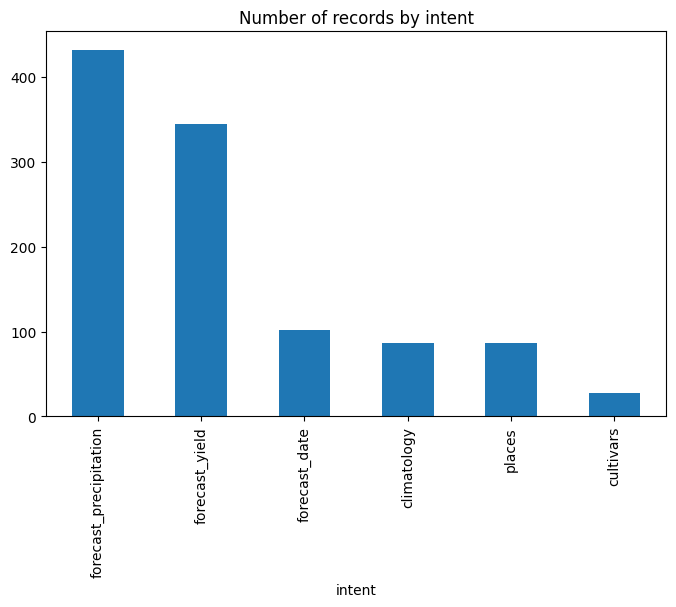

In [41]:
# Number of records by intent
plt.figure(figsize=(8,5))
ax2 = intent2_r_df['intent'].value_counts().plot(kind='bar')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Number of records by intent")

# BIO-Annotation

In [43]:
# Create
step6 = "06-bio-tags"
step6_ws = os.path.join(workspace,step6)
os.makedirs(step6_ws, exist_ok=True)
file_bio_v1 = os.path.join(step6_ws,"01-bio_v1.csv")

In [77]:

intent2_r_df = pd.read_csv(file_intent_reviewed_focus,encoding=cf.encoding)

import spacy
from spacy.tokens import Doc, Span

# Load the spaCy model for Spanish
nlp = spacy.load("es_core_news_sm")

labels_spacy = []
# Function to perform BIO tagging for entities
def bio_tagging(text):
    doc = nlp(text)
    tags = ['O'] * len(doc)

    # Dictionary to map entities to their labels
    entity_labels = {
        'place': ['cali','san','valle','cauca','cordova','magangué','córdoba','cordoba','doctrina','césar','sucre','espinal','meta','saldaña','montería','buga','cereté','tolima','palmira','ibague','nariño','cerete','huila','casanare','lorica','antioquia','ibagué','corea','puerto','santander','pance','neiva','granada','ibague','zona','sector'],
        'crop': ['arroz','maíz','maiz','yuca','ñame','papa','potato','mango','frijoles','canabis','cacao','frijol','pepino','cannabis','aguacate','algodón','cafe','maracuyá'],
        'measure': ['precipitación','precipitacion','lluvia','lluvias', 'temperatura','radiación','humedad','evapotranspiracion','agua','brillo','llover','precipitaciones','llueve'],
        'date': ['hoy','agosto','septiembre','octubre','semana','2021','2022','2023','diciembre','enero']
    }

    for ent_type, ent_labels in entity_labels.items():
        for label in ent_labels:
            for i, token in enumerate(doc):
                if token.text.lower() == label:
                    tags[i] = 'B-' + ent_type
                    for j in range(i + 1, i + len(label.split())):
                        tags[j] = 'I-' + ent_type

    return tags


# Apply BIO tagging to the 'text' column
intent2_r_df['bio_tags'] = intent2_r_df['text'].apply(bio_tagging)

intent2_r_df.to_csv(file_bio_v1,encoding=cf.encoding,index=False)

# Print the first few rows to verify the tagging
print(intent2_r_df.head())

     id            source       intent  \
0  2104  inputs_chats.csv  climatology   
1  1056  inputs_chats.csv  climatology   
2  2392  inputs_chats.csv  climatology   
3  2394  inputs_chats.csv  climatology   
4  2395  inputs_chats.csv  climatology   

                                                text  word_length  \
0  Buenos días Solicito precipitación de los mese...           17   
1    Como seran las lluvias para esta semana en cali            9   
2  Cual es la humedad relativa en San Bernardo de...           11   
3  Cual es la humedad relativa en la doctrina cor...            9   
4            Datos climáticos de la doctrina Córdoba            6   

   character_length                                           bio_tags  
0               108  [O, O, O, B-measure, O, O, O, O, B-date, B-dat...  
1                47     [O, O, O, B-measure, O, O, B-date, O, B-place]  
2                62  [O, O, O, B-measure, O, O, B-place, O, O, O, B...  
3                50    [O, O, O, B-measu

# Others

In [5]:
# Create
step7 = "07-others"
step7_ws = os.path.join(workspace,step7)
os.makedirs(step7_ws, exist_ok=True)
file_others_full_v1 = os.path.join(step7_ws,"01-others-v1.csv")

     id                                               text   intent  \
0  2090  DATO PRELIMINAR\nEstación: Cahabón A. V\nObser...  agrilac   
1  2091  DATO PRELIMINAR\nEstación: Cahabón A. V\nObser...  agrilac   
2  2092  DATO PRELIMINAR\nEstación: Cahabón A. V\nObser...  agrilac   
3  2093  DATO PRELIMINAR\nEstación: Cahabón A. V\nObser...  agrilac   
4  2094  DATO PRELIMINAR\nEstación: Cahabón A. V\nObser...  agrilac   

             source  
0  inputs_chats.csv  
1  inputs_chats.csv  
2  inputs_chats.csv  
3  inputs_chats.csv  
4  inputs_chats.csv  
     id                                  text intent            source
0  2516  A que distancia debo sembrar el mauz  other  inputs_chats.csv
1   185                                 AYUDA  other  inputs_chats.csv
2  1210                                 Adiós  other  inputs_chats.csv
3  2096                                  Agua  other  inputs_chats.csv
4   847         Ahí fallos en este algorithmo  other  inputs_chats.csv


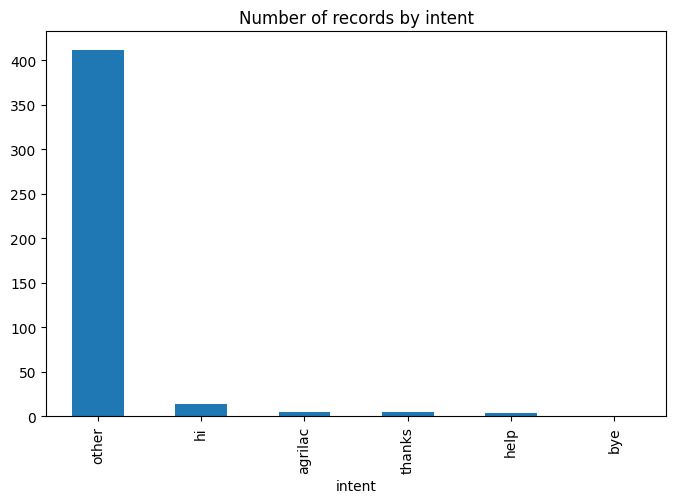

In [10]:
others1_df = pd.read_csv(file_others,encoding=cf.encoding)
print(others1_df.head())
others2_df = pd.read_csv(file_intent_reviewed_others,encoding=cf.encoding)
print(others2_df.head())
others_df_v1 = pd.concat([others1_df, others2_df], ignore_index=True)

others_df_v1 = others_df_v1.sort_values(by=['intent','text','source'])
others_df_v1 = others_df_v1.drop_duplicates(subset=['text','intent'])

# Number of records by intent
plt.figure(figsize=(8,5))
ax3 = others_df_v1['intent'].value_counts().plot(kind='bar')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Number of records by intent")

others_df_v1.to_csv(file_others_full_v1,encoding=cf.encoding,index=False)


In [32]:
#intent_df = pd.read_csv(file_intent_v1,encoding=cf.encoding_utf)

# Others
#exp_1 = ['cual','sido','cómo']
#condition1 = intent_df['text'].str.isin(exp_1)


#intent_df.loc[condition1, 'new_intent'] = 'others'

#intent_df.to_csv(file_intent_others,encoding=cf.encoding_utf,index=False)

In [5]:
sampled_df = pd.read_csv(file_intent_sample_manual,encoding=cf.encoding_utf)
sampled_df.head()

,id,source,intent,text,word_length,character_length,new_intent
0,570,inputs_mta.csv,places,Cuál es el pronóstico climático para Jamundí,7,44,forecast_precipitation
1,644,inputs_mta.csv,places,Cuál es el pronóstico climático para Valledupar,7,47,forecast_precipitation
2,2347,inputs_mta.csv,places,Información agroclimatica para el tolima,5,40,forecast_precipitation
3,2886,inputs_mta.csv,places,tiene acceso a información sobre pronósticos c...,7,55,forecast_precipitation
4,1238,inputs_mta.csv,places,Cuál es el pronóstico climático para el Quindío,8,47,forecast_precipitation


In [1]:
#!pip install langdetect googletrans==4.0.0-rc1

from langdetect import detect
from googletrans import Translator

def detect_and_translate_to_spanish(text):
    # Detect the language of the text
    detected_language = detect(text)
    print(detected_language)

    # Translate to Spanish if the detected language is not Spanish
    if detected_language != 'es':
        translator = Translator()
        translation = translator.translate(text, src=detected_language, dest='es')
        translated_text = translation.text
    else:
        # Text is already in Spanish
        translated_text = text
    
    return translated_text

# Example text
example_text = "Hello, how are you?"

# Detect language and translate to Spanish
translated_text = detect_and_translate_to_spanish(example_text)

# Print the translated text
print("Translated text in Spanish:")
print(translated_text)

en
Translated text in Spanish:
¿Hola, cómo estás?
